##Imports and prepearing data for the model

In [3]:
!pip install darts #numpy==2.0.1

In [4]:
# Imports
import pandas as pd
from darts import TimeSeries
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [ ]:
# Connect and load data from google drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/data_g.csv")

display(data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
0,18790,2013-01-02,24,105574,12.0,NaN,GROCERY I,1045,0
1,18791,2013-01-02,24,105575,2.0,NaN,GROCERY I,1045,0
2,18792,2013-01-02,24,105577,1.0,NaN,GROCERY I,1045,0
3,18793,2013-01-02,24,105693,7.0,NaN,GROCERY I,1034,0
4,18794,2013-01-02,24,105737,17.0,NaN,GROCERY I,1044,0
...,...,...,...,...,...,...,...,...,...
2747270,21656539,2014-03-31,51,1464239,4.0,NaN,BEVERAGES,1144,0
2747271,21656540,2014-03-31,51,1464246,3.0,NaN,BEVERAGES,1148,0
2747272,21656541,2014-03-31,51,1464941,18.0,NaN,BEVERAGES,1148,0
2747273,21656542,2014-03-31,51,1466047,5.0,NaN,BEVERAGES,1114,0


In [ ]:
#Filter dataframe for one store and one item
df = data[(data["store_nbr"]==24) & (data["item_nbr"]==105737)]

# Make sure the 'date' column is in datetime format
df["date"] = pd.to_datetime(df["date"])

# Set 'date' as index
df.set_index('date', inplace = True)

# Sort data by date
df.sort_index(inplace = True)

#Data frame for SARIMA model
df_sarima = df[["unit_sales"]]

# Aggregate sales at the daily level
df_sarima = df_sarima.groupby('date')['unit_sales'].sum()

# Fill missing dates with zero sales (since some dates may have no sales)
df_sarima = df_sarima.asfreq('D').fillna(0)

#Convert series to dataframe
df_sarima = df_sarima.to_frame()

df_sarima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 454 entries, 2013-01-02 to 2014-03-31
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   unit_sales  454 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


<ipython-input-115-c189a7cc51c0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"] = pd.to_datetime(df["date"])


ADF Statistic: -21.11473561368218
p-value: 0.0


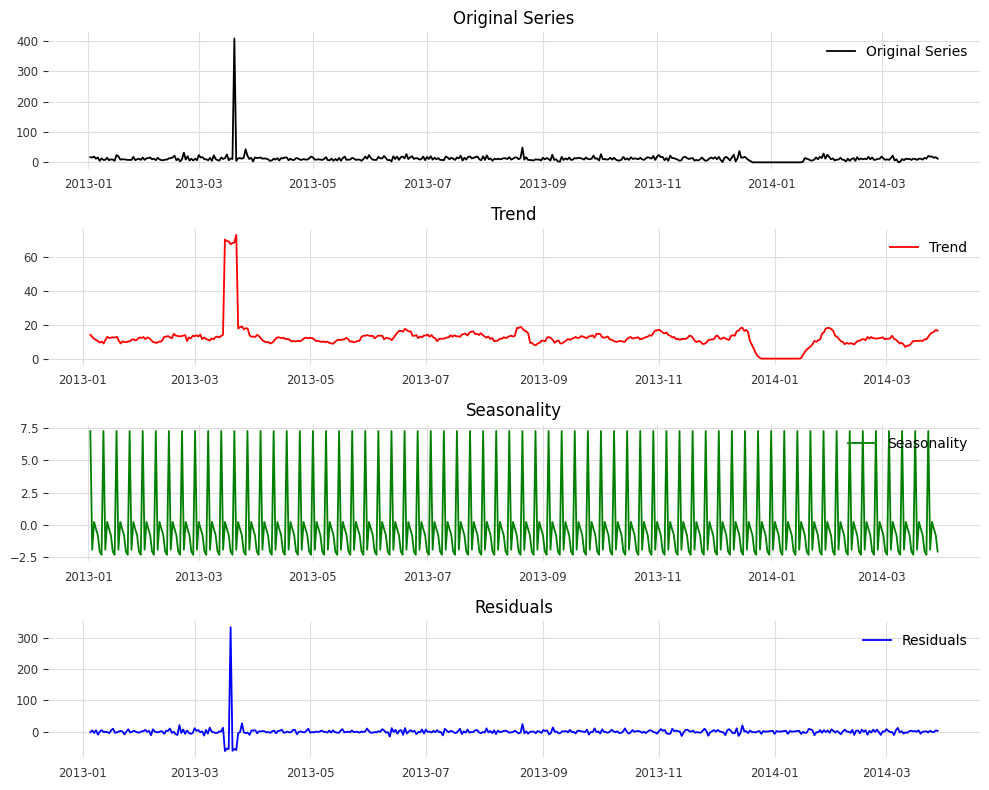

In [ ]:
# Check series for seasonality

# Perform ADF test
result = adfuller(df_sarima['unit_sales'])

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

decomposition = seasonal_decompose(df_sarima['unit_sales'], model='additive', period=7)

# Plot the decomposition
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(df_sarima['unit_sales'], label='Original Series')
plt.legend(loc='best')
plt.title('Original Series')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend(loc='best')
plt.title('Trend')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.legend(loc='best')
plt.title('Seasonality')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='blue')
plt.legend(loc='best')
plt.title('Residuals')

plt.tight_layout()
plt.show()


### Since Series has seasonal component, I will use SARIMA, so it can capture this component and give better prediction than ARIMA (wich assumes that data is non-seasonal)

##SARIMA Model

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 8.07
MAE: 6.22
AIC: 3146.56
BIC: 3184.97


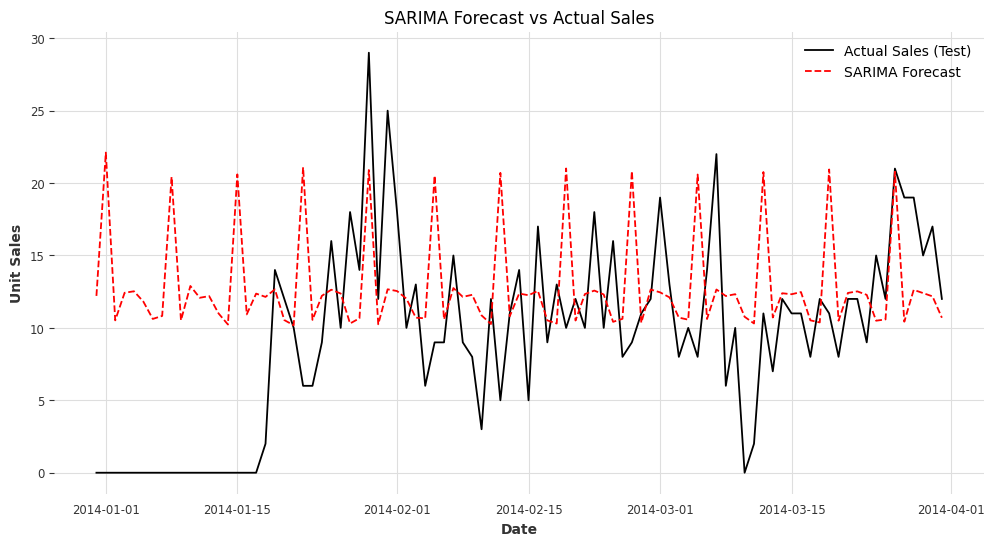

In [ ]:
# Build SARIMA model

# Ensure index is datetime format
df_sarima.index = pd.to_datetime(df_sarima.index)

# Ensure data is sorted by date
df_sarima = df_sarima.sort_index()

# Train-test split (80% training, 20% testing)
train_size = int(len(df_sarima) * 0.8)
train, test = df_sarima.iloc[:train_size], df_sarima.iloc[train_size:]

# Define and fit the SARIMA model
model = SARIMAX(train['unit_sales'],
                order=(5,0,2),
                seasonal_order=(1,1,1,7),  # Weekly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

sarima_fit = model.fit()

# Forecast for test set
sarima_forecast = sarima_fit.predict(start=len(train), end=len(df_sarima)-1, dynamic=False)

# Model metrics
rmse = np.sqrt(mean_squared_error(test['unit_sales'], sarima_forecast))
mae = mean_absolute_error(test['unit_sales'], sarima_forecast)
aic = sarima_fit.aic
bic = sarima_fit.bic

print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'AIC: {aic:.2f}')
print(f'BIC: {bic:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['unit_sales'], label='Actual Sales (Test)', color='black')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='dashed')
plt.legend()
plt.title('SARIMA Forecast vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.grid(True)
plt.show()



#SARIMA Model Summary

I chose the SARIMA (Seasonal AutoRegressive Integrated Moving Average) model because:




*   ADF Test Result: The ADF test confirms the series is stationary (p-value < 0.05, ADF Statistic = -17.52).
*   Seasonality Observed: Seasonal patterns were evident from decomposition.


##Model Performance (Weekly SARIMA)

    

* RMSE (Root Mean Square Error): 8.07 → Measures prediction error; lower is    better.

* MAE (Mean Absolute Error): 6.22 → Indicates average deviation of predictions.


* AIC (Akaike Information Criterion): 3146 → Used for model comparison; lower AIC is preferable.

* BIC (Bayesian Information Criterion): 3184 → Penalizes model complexity; helps avoid overfitting.



##Conclusion
SARIMA was chosen due to the presence of seasonality in the data. The model’s performance is reasonable, but XGBoost provides better predictions in this case.
